In [72]:
from mnist import MNIST
import numpy as np
import matplotlib.pyplot as plt
IMG_DIM = 28

In [73]:
mndata = MNIST('../mnist')
train_images, train_labels = mndata.load_training()
test_images, test_labels = mndata.load_testing()

train_images, train_labels = np.array(train_images), np.array(train_labels)
test_images, test_labels = np.array(test_images), np.array(test_labels)

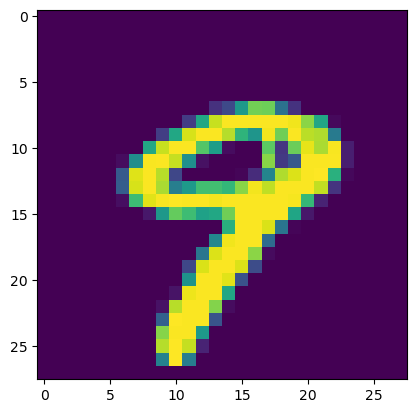

In [74]:
plt.imshow(test_images[9].reshape(IMG_DIM, IMG_DIM))
plt.show()
# print(f"train_images.shape: {train_images.shape}")
# print(f"test_images.shape: {test_images.shape}")
# print(test_images[0])

In [75]:
# Creating validation set and convert to tensors
from sklearn.model_selection import train_test_split 
import logging as log
import torch
train_images.shape, train_labels.shape
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.10)

n_train, n_val = train_images.shape[0], val_images.shape[0]
train_images = train_images.reshape(n_train, 1, IMG_DIM, IMG_DIM)
val_images = val_images.reshape(n_val, 1, IMG_DIM, IMG_DIM)
# train_images, val_images = train_images.astype(float), val_images.astype(float)
train_images, val_images = torch.from_numpy(train_images), torch.from_numpy(val_images)

train_labels, val_labels = train_labels.astype(int), val_labels.astype(int)
train_labels, val_labels = torch.from_numpy(train_labels), torch.from_numpy(val_labels)


In [76]:
# Let's define some variables
DEVICE = torch.device("cude" if torch.cuda.is_available() else "cpu")
N_EPOCHS = 100
BATCH_SIZE = 100
N_CLASSES = (train_labels.max() + 1).item()

In [180]:
# Create CNN
import torch.nn as nn
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.seq1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.seq2 = nn.Sequential(
            nn.Conv2d(32, 13, kernel_size=5, stride=1, padding=1),
            nn.BatchNorm2d(13),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        ) 
        self.seq3 = nn.Sequential(
            nn.Linear(13*5*5, 120),
            nn.Linear(120, 10),
        )
    
    def forward(self, x):
        x = self.seq1(x)
        x = self.seq2(x)
        x = x.view(x.size(0), -1)
        x = self.seq3(x)
        return x


img = train_images[:BATCH_SIZE].type(torch.FloatTensor)
cnn = CNN()
cnn.train()
# x = cnn.forward(img)
# print(f"cnn: {cnn}")
# print(f"x.size(): {x.size()}")
# s = nn.Softmax(10)
# y = s(x)
# print(f"y.size(): {y.size()}")

CNN(
  (seq1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (seq2): Sequential(
    (0): Conv2d(32, 13, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(13, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (seq3): Sequential(
    (0): Linear(in_features=325, out_features=120, bias=True)
    (1): Linear(in_features=120, out_features=10, bias=True)
  )
)